## DATA ANALYSIS

16th March

The goal of this notebook is creating a CNN to analyse previously produced data.

### Packages

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D


## DATA renormalization

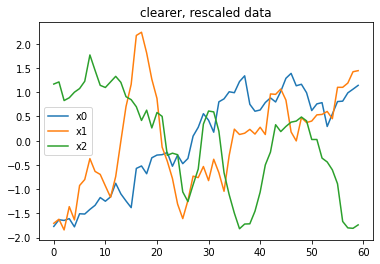

[1. 0. 0.]
10000 8000 2000 60


In [2]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000'
fnamex = 'DATA/x_'+str0+'.csv'
fnamey = 'DATA/y_'+str0+'.csv'

x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
N = len(x)

xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.title('clearer, rescaled data')
plt.legend()
plt.show()    


categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1             #one-hot encoding
print(y[0])


perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

L = len(x[0])
print(N,N_train, N_val,L)


x_train = x_train.reshape(x_train.shape[0],L,1)    #reshaping
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

In [3]:
reg = regularizers.l2(0.01)    #LASSO, lambda = 10e-4
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

model = Sequential()
model.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 11,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model.add(AveragePooling1D(5))                          #Reduce 5 -> 1

model.add(Conv1D(                                       #Second layer
                filters = 5,
                kernel_size = 7,
                activation = 'relu'
                ))
model.add(Flatten())                                      #Move to GNN
model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary())   #Notice how few parameters!

NameError: name 'input_shape' is not defined

In [4]:

opt = optimizers.SGD(lr = 0.01, momentum = 0.9, nesterov = True, decay = 1e-6)

model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])

#after a compilation of the network we save in 'initial.h5' the weight at the beginning
model.save_weights('initial.h5')

In [5]:
batch_size = 250
epochs = 100
fit = model.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 2
               )

Epoch 1/100
32/32 - 7s - loss: 1.1038 - accuracy: 0.3298 - val_loss: 1.0968 - val_accuracy: 0.3735
Epoch 2/100
32/32 - 0s - loss: 1.0956 - accuracy: 0.3643 - val_loss: 1.0907 - val_accuracy: 0.4050
Epoch 3/100
32/32 - 0s - loss: 1.0899 - accuracy: 0.3868 - val_loss: 1.0820 - val_accuracy: 0.4130
Epoch 4/100
32/32 - 0s - loss: 1.0801 - accuracy: 0.4135 - val_loss: 1.0668 - val_accuracy: 0.4515
Epoch 5/100
32/32 - 1s - loss: 1.0684 - accuracy: 0.4224 - val_loss: 1.0491 - val_accuracy: 0.4700
Epoch 6/100
32/32 - 0s - loss: 1.0502 - accuracy: 0.4466 - val_loss: 1.0271 - val_accuracy: 0.4885
Epoch 7/100
32/32 - 0s - loss: 1.0329 - accuracy: 0.4596 - val_loss: 1.0055 - val_accuracy: 0.5090
Epoch 8/100
32/32 - 0s - loss: 1.0119 - accuracy: 0.4863 - val_loss: 0.9800 - val_accuracy: 0.5280
Epoch 9/100
32/32 - 0s - loss: 0.9902 - accuracy: 0.4976 - val_loss: 0.9534 - val_accuracy: 0.5450
Epoch 10/100
32/32 - 0s - loss: 0.9681 - accuracy: 0.5182 - val_loss: 0.9344 - val_accuracy: 0.5590
Epoch 11/

32/32 - 0s - loss: 0.6339 - accuracy: 0.7477 - val_loss: 0.6198 - val_accuracy: 0.7545
Epoch 84/100
32/32 - 0s - loss: 0.6281 - accuracy: 0.7484 - val_loss: 0.6203 - val_accuracy: 0.7555
Epoch 85/100
32/32 - 0s - loss: 0.6250 - accuracy: 0.7517 - val_loss: 0.6133 - val_accuracy: 0.7595
Epoch 86/100
32/32 - 0s - loss: 0.6237 - accuracy: 0.7549 - val_loss: 0.6114 - val_accuracy: 0.7625
Epoch 87/100
32/32 - 0s - loss: 0.6173 - accuracy: 0.7575 - val_loss: 0.6142 - val_accuracy: 0.7635
Epoch 88/100
32/32 - 0s - loss: 0.6189 - accuracy: 0.7544 - val_loss: 0.6183 - val_accuracy: 0.7590
Epoch 89/100
32/32 - 0s - loss: 0.6220 - accuracy: 0.7536 - val_loss: 0.6053 - val_accuracy: 0.7615
Epoch 90/100
32/32 - 0s - loss: 0.6164 - accuracy: 0.7594 - val_loss: 0.6026 - val_accuracy: 0.7640
Epoch 91/100
32/32 - 0s - loss: 0.6102 - accuracy: 0.7638 - val_loss: 0.5973 - val_accuracy: 0.7620
Epoch 92/100
32/32 - 0s - loss: 0.6031 - accuracy: 0.7640 - val_loss: 0.5971 - val_accuracy: 0.7635
Epoch 93/100


As we can see now the performance are really better!

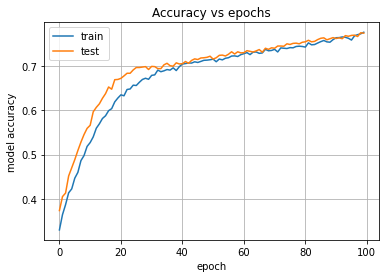

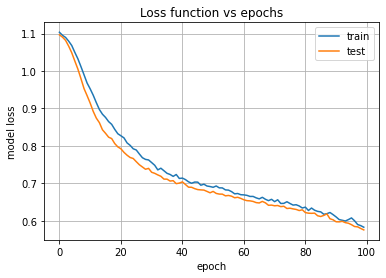

In [6]:
#Plot

# accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()
# loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Loss function vs epochs')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

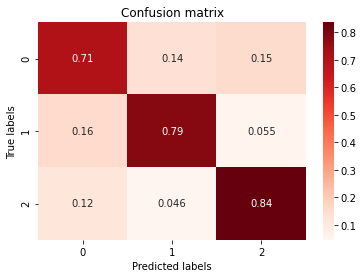

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_val  = model.predict(x_val)
#take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
sns.heatmap(confusion_Oz, annot = True, cmap = plt.cm.Reds, fmt = '.2g')

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix')
plt.show()

100%|██████████| 12/12 [10:07<00:00, 50.59s/it]


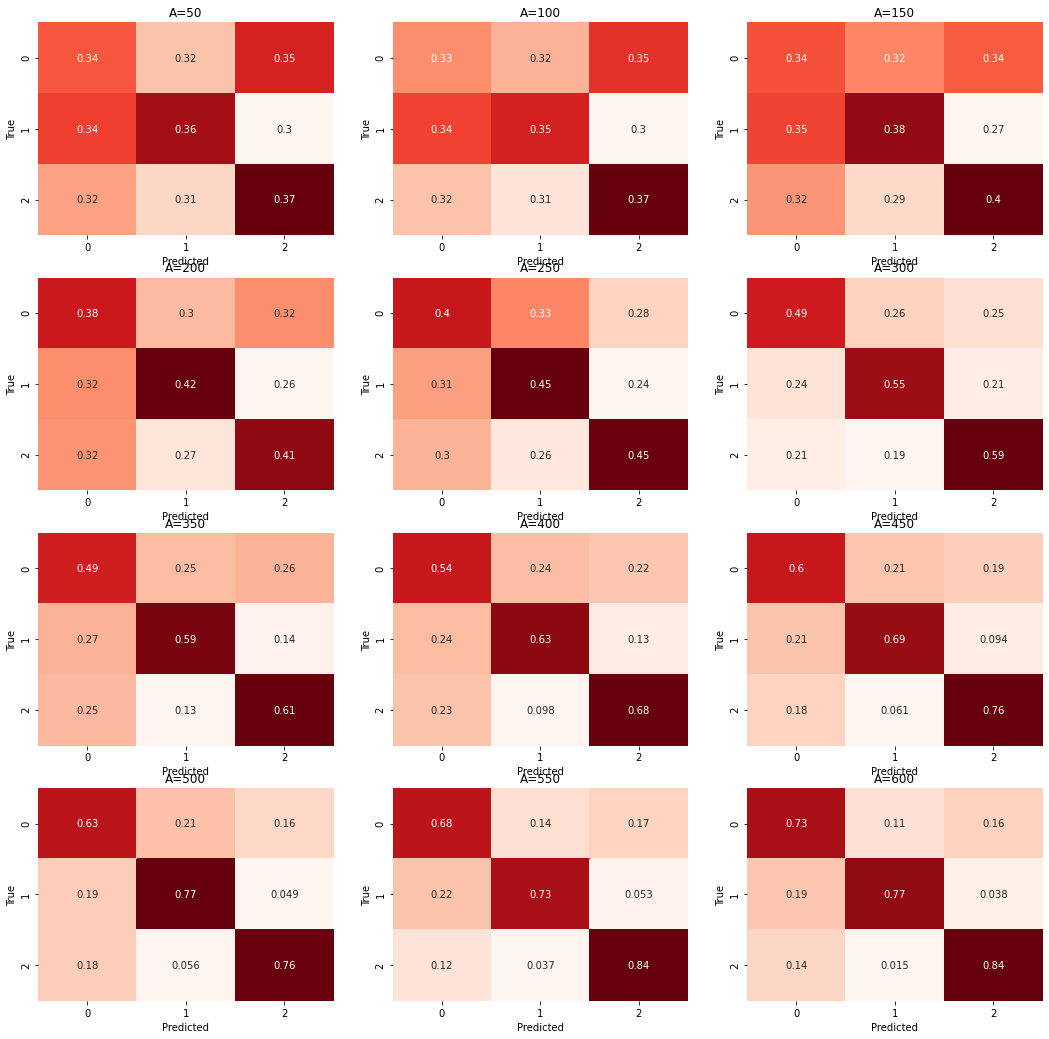

{50: 0.35620625168085096, 100: 0.37803750187158586, 150: 0.3885500028729439, 200: 0.4023687466979027, 250: 0.42791875153779985, 300: 0.526406255364418, 350: 0.5503062516450882, 400: 0.6065437525510788, 450: 0.6663062512874603, 500: 0.7041874945163726, 550: 0.7339374989271163, 600: 0.777581250667572}


In [8]:
from tqdm import tqdm

fig, ax = plt.subplots(4, 3, figsize=(18,18))
As = np.arange(50,650,50)
scores = {}

for a in tqdm(range(len((As)))):
    
    #if statements to define the grid for the subplots
    if a < 3:
        i = 0
        j = a
    elif a < 6:
        i = 1
        j = a-3
    elif a < 9:
        i = 2
        j = a-6
    elif a < 12:
        i = 3
        j = a-9
    elif a < 15:
        i = 4
        j = a-12
    
    str0 = f'ts_L60_Z12_A{As[a]}_DX50_bias5_N10000'
    fnamex = 'DATA/x_'+str0+'.csv'
    fnamey = 'DATA/y_'+str0+'.csv'
    
    x = np.loadtxt(fnamex, delimiter = ',', dtype = float)
    N = len(x)

    xm = x.mean(axis = 1)
    stdx = x.std(axis = 1)
    for n in range(N):
        x[n] -= xm[n]
        x[n] /= stdx[n]

    categ = np.loadtxt(fnamey, delimiter = ',', dtype = int)
    N_categ = np.max(categ)+1
    y = np.zeros((N,N_categ))
    for n in range(N):
        y[n][categ[n]] = 1             

    perc_train = 0.8                    
    N_train = int(N*perc_train)
    N_val = N - N_train

    x_train, y_train = x[:N_train], y[:N_train]
    x_val, y_val = x[N_train:], y[N_train:]

    L = len(x[0])

    x_train = x_train.reshape(x_train.shape[0],L,1)   
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)
    
    #at each step of the for loop we recover the initial weights in order to start always from the same model
    model.load_weights('initial.h5')
    fit = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (x_val,y_val),
                    verbose = 0
                   )
    scores[As[a]] = np.mean(fit.history['accuracy'][-20:])
    
    y_pred_val  = model.predict(x_val)
    max_y_pred_val = np.argmax(y_pred_val, axis=1)
    max_y_val = np.argmax(y_val, axis=1)
    confusion_Oz = confusion_matrix(max_y_pred_val,max_y_val, normalize='true') 
 
    g = sns.heatmap(confusion_Oz,
                    annot = True,
                    cmap = plt.cm.Reds,
                    cbar = False,
                    fmt = '.2g',
                    ax = ax[i][j]
                   )
    g.set_ylabel('True')
    g.set_xlabel('Predicted')
    g.set_title(f'A={As[a]}')

plt.show()
print(scores)   

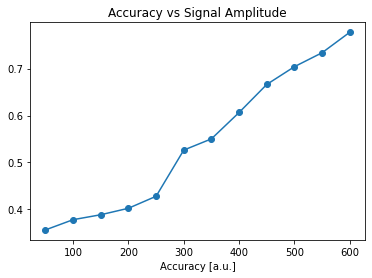

In [9]:
keys_int = []
as_accuracy = []
for k in scores.keys():
    keys_int.append(k)
    as_accuracy.append(scores.get(k))
plt.title('Accuracy vs Signal Amplitude')
plt.xlabel('Signal Amplitude [a.u.]')
plt.xlabel('Accuracy [a.u.]')
plt.plot(keys_int, as_accuracy, '-o')
plt.show()

#### new data

In [45]:

str1 = 'ts_comp_N10000'
fnamex1 = 'DATA/x_'+str1+'.csv'
fnamey1 = 'DATA/y_'+str1+'.csv'

x = np.loadtxt(fnamex1, delimiter = ',', dtype = float)
categ = np.loadtxt(fnamey1, delimiter = ',', dtype = int)

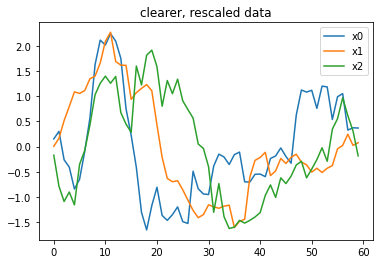

[0. 1. 0.]
10000 8000 2000 60


In [46]:
N = len(x)

xm = x.mean(axis = 1)
stdx = x.std(axis = 1)
for n in range(N):
    x[n] -= xm[n]
    x[n] /= stdx[n]
    
plt.plot(x[0], label='x0')
plt.plot(x[1], label='x1')
plt.plot(x[2], label='x2')
plt.title('clearer, rescaled data')
plt.legend()
plt.show()    



N_categ = np.max(categ)+1
y = np.zeros((N,N_categ))
for n in range(N):
    y[n][categ[n]] = 1             #one-hot encoding
print(y[0])


perc_train = 0.8                    
N_train = int(N*perc_train)
N_val = N - N_train

x_train, y_train = x[:N_train], y[:N_train]
x_val, y_val = x[N_train:], y[N_train:]

L = len(x[0])
print(N,N_train, N_val,L)


x_train = x_train.reshape(x_train.shape[0],L,1)    #reshaping
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)
#print((x_train[0]))

### keeping just one Conv1d, adding dense

In [35]:
reg = regularizers.l2(0.01)    #LASSO, lambda = 10e-4
np.random.seed(12345)
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)
batch_size = 250
epochs = 250

model = Sequential()
model.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 11,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model.add(AveragePooling1D(10))                          #Reduce 5 -> 1
model.add(Flatten())                                     #Move to GNN
model.add(Dense(10,activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary()) 
model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])


fit1 = model.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )




Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_19 (Averag (None, 5, 5)              0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 25)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 10)                260       
_________________________________________________________________
dropout_22 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 3)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_______________________________________________________

Epoch 72/250
32/32 - 1s - loss: 0.8727 - accuracy: 0.5414 - val_loss: 0.8442 - val_accuracy: 0.5605
Epoch 73/250
32/32 - 1s - loss: 0.8704 - accuracy: 0.5436 - val_loss: 0.8416 - val_accuracy: 0.5675
Epoch 74/250
32/32 - 1s - loss: 0.8645 - accuracy: 0.5418 - val_loss: 0.8392 - val_accuracy: 0.5615
Epoch 75/250
32/32 - 1s - loss: 0.8662 - accuracy: 0.5474 - val_loss: 0.8352 - val_accuracy: 0.5640
Epoch 76/250
32/32 - 1s - loss: 0.8608 - accuracy: 0.5525 - val_loss: 0.8314 - val_accuracy: 0.5705
Epoch 77/250
32/32 - 1s - loss: 0.8587 - accuracy: 0.5502 - val_loss: 0.8308 - val_accuracy: 0.5715
Epoch 78/250
32/32 - 1s - loss: 0.8567 - accuracy: 0.5460 - val_loss: 0.8269 - val_accuracy: 0.5730
Epoch 79/250
32/32 - 1s - loss: 0.8543 - accuracy: 0.5483 - val_loss: 0.8245 - val_accuracy: 0.5755
Epoch 80/250
32/32 - 1s - loss: 0.8527 - accuracy: 0.5566 - val_loss: 0.8213 - val_accuracy: 0.5760
Epoch 81/250
32/32 - 1s - loss: 0.8507 - accuracy: 0.5625 - val_loss: 0.8217 - val_accuracy: 0.5710


Epoch 154/250
32/32 - 1s - loss: 0.6783 - accuracy: 0.6839 - val_loss: 0.6348 - val_accuracy: 0.7315
Epoch 155/250
32/32 - 1s - loss: 0.6817 - accuracy: 0.6865 - val_loss: 0.6349 - val_accuracy: 0.7315
Epoch 156/250
32/32 - 1s - loss: 0.6784 - accuracy: 0.6901 - val_loss: 0.6369 - val_accuracy: 0.7375
Epoch 157/250
32/32 - 1s - loss: 0.6796 - accuracy: 0.6849 - val_loss: 0.6345 - val_accuracy: 0.7420
Epoch 158/250
32/32 - 1s - loss: 0.6804 - accuracy: 0.6814 - val_loss: 0.6348 - val_accuracy: 0.7405
Epoch 159/250
32/32 - 1s - loss: 0.6756 - accuracy: 0.6908 - val_loss: 0.6319 - val_accuracy: 0.7400
Epoch 160/250
32/32 - 1s - loss: 0.6757 - accuracy: 0.6902 - val_loss: 0.6368 - val_accuracy: 0.7300
Epoch 161/250
32/32 - 1s - loss: 0.6744 - accuracy: 0.6916 - val_loss: 0.6303 - val_accuracy: 0.7355
Epoch 162/250
32/32 - 1s - loss: 0.6731 - accuracy: 0.6992 - val_loss: 0.6307 - val_accuracy: 0.7310
Epoch 163/250
32/32 - 1s - loss: 0.6804 - accuracy: 0.6917 - val_loss: 0.6284 - val_accurac

32/32 - 0s - loss: 0.6440 - accuracy: 0.7103 - val_loss: 0.6000 - val_accuracy: 0.7555
Epoch 236/250
32/32 - 0s - loss: 0.6405 - accuracy: 0.7138 - val_loss: 0.6003 - val_accuracy: 0.7510
Epoch 237/250
32/32 - 0s - loss: 0.6404 - accuracy: 0.7130 - val_loss: 0.6004 - val_accuracy: 0.7550
Epoch 238/250
32/32 - 0s - loss: 0.6394 - accuracy: 0.7150 - val_loss: 0.5991 - val_accuracy: 0.7575
Epoch 239/250
32/32 - 0s - loss: 0.6451 - accuracy: 0.7081 - val_loss: 0.6019 - val_accuracy: 0.7575
Epoch 240/250
32/32 - 0s - loss: 0.6423 - accuracy: 0.7186 - val_loss: 0.5994 - val_accuracy: 0.7515
Epoch 241/250
32/32 - 0s - loss: 0.6369 - accuracy: 0.7204 - val_loss: 0.6011 - val_accuracy: 0.7550
Epoch 242/250
32/32 - 0s - loss: 0.6367 - accuracy: 0.7182 - val_loss: 0.5999 - val_accuracy: 0.7585
Epoch 243/250
32/32 - 0s - loss: 0.6392 - accuracy: 0.7154 - val_loss: 0.5985 - val_accuracy: 0.7570
Epoch 244/250
32/32 - 0s - loss: 0.6396 - accuracy: 0.7122 - val_loss: 0.5988 - val_accuracy: 0.7505
Epoc

In [36]:

model = Sequential()
model.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 11,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model.add(AveragePooling1D(10))                          #Reduce 5 -> 1
model.add(Flatten())                                     #Move to GNN
model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary()) 
model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])


fit2 = model.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_20 (Averag (None, 5, 5)              0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 25)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_56 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_23 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 3)               

Epoch 71/250
32/32 - 0s - loss: 0.6429 - accuracy: 0.7079 - val_loss: 0.6063 - val_accuracy: 0.7440
Epoch 72/250
32/32 - 0s - loss: 0.6412 - accuracy: 0.7104 - val_loss: 0.6108 - val_accuracy: 0.7445
Epoch 73/250
32/32 - 0s - loss: 0.6385 - accuracy: 0.7082 - val_loss: 0.6063 - val_accuracy: 0.7460
Epoch 74/250
32/32 - 0s - loss: 0.6374 - accuracy: 0.7094 - val_loss: 0.6043 - val_accuracy: 0.7475
Epoch 75/250
32/32 - 0s - loss: 0.6388 - accuracy: 0.7088 - val_loss: 0.6061 - val_accuracy: 0.7460
Epoch 76/250
32/32 - 0s - loss: 0.6412 - accuracy: 0.7120 - val_loss: 0.6062 - val_accuracy: 0.7475
Epoch 77/250
32/32 - 0s - loss: 0.6428 - accuracy: 0.7099 - val_loss: 0.6035 - val_accuracy: 0.7490
Epoch 78/250
32/32 - 0s - loss: 0.6397 - accuracy: 0.7163 - val_loss: 0.6022 - val_accuracy: 0.7455
Epoch 79/250
32/32 - 0s - loss: 0.6362 - accuracy: 0.7170 - val_loss: 0.6033 - val_accuracy: 0.7440
Epoch 80/250
32/32 - 0s - loss: 0.6379 - accuracy: 0.7175 - val_loss: 0.6021 - val_accuracy: 0.7460


Epoch 153/250
32/32 - 0s - loss: 0.5764 - accuracy: 0.7577 - val_loss: 0.5543 - val_accuracy: 0.7835
Epoch 154/250
32/32 - 0s - loss: 0.5794 - accuracy: 0.7549 - val_loss: 0.5551 - val_accuracy: 0.7775
Epoch 155/250
32/32 - 0s - loss: 0.5823 - accuracy: 0.7559 - val_loss: 0.5538 - val_accuracy: 0.7810
Epoch 156/250
32/32 - 0s - loss: 0.5821 - accuracy: 0.7540 - val_loss: 0.5497 - val_accuracy: 0.7870
Epoch 157/250
32/32 - 0s - loss: 0.5770 - accuracy: 0.7541 - val_loss: 0.5551 - val_accuracy: 0.7750
Epoch 158/250
32/32 - 0s - loss: 0.5754 - accuracy: 0.7589 - val_loss: 0.5520 - val_accuracy: 0.7810
Epoch 159/250
32/32 - 0s - loss: 0.5735 - accuracy: 0.7571 - val_loss: 0.5530 - val_accuracy: 0.7890
Epoch 160/250
32/32 - 0s - loss: 0.5767 - accuracy: 0.7567 - val_loss: 0.5492 - val_accuracy: 0.7810
Epoch 161/250
32/32 - 0s - loss: 0.5749 - accuracy: 0.7611 - val_loss: 0.5474 - val_accuracy: 0.7850
Epoch 162/250
32/32 - 0s - loss: 0.5823 - accuracy: 0.7601 - val_loss: 0.5470 - val_accurac

32/32 - 0s - loss: 0.5493 - accuracy: 0.7769 - val_loss: 0.5331 - val_accuracy: 0.7965
Epoch 235/250
32/32 - 0s - loss: 0.5458 - accuracy: 0.7782 - val_loss: 0.5316 - val_accuracy: 0.7990
Epoch 236/250
32/32 - 0s - loss: 0.5460 - accuracy: 0.7766 - val_loss: 0.5367 - val_accuracy: 0.8025
Epoch 237/250
32/32 - 0s - loss: 0.5511 - accuracy: 0.7757 - val_loss: 0.5325 - val_accuracy: 0.7940
Epoch 238/250
32/32 - 0s - loss: 0.5480 - accuracy: 0.7789 - val_loss: 0.5283 - val_accuracy: 0.8010
Epoch 239/250
32/32 - 0s - loss: 0.5454 - accuracy: 0.7763 - val_loss: 0.5291 - val_accuracy: 0.8020
Epoch 240/250
32/32 - 0s - loss: 0.5501 - accuracy: 0.7747 - val_loss: 0.5295 - val_accuracy: 0.7975
Epoch 241/250
32/32 - 0s - loss: 0.5472 - accuracy: 0.7756 - val_loss: 0.5327 - val_accuracy: 0.7975
Epoch 242/250
32/32 - 0s - loss: 0.5466 - accuracy: 0.7799 - val_loss: 0.5376 - val_accuracy: 0.8005
Epoch 243/250
32/32 - 0s - loss: 0.5540 - accuracy: 0.7760 - val_loss: 0.5320 - val_accuracy: 0.8005
Epoc

In [37]:
model = Sequential()
model.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 11,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))
model.add(AveragePooling1D(10))                          #Reduce 5 -> 1
model.add(Flatten())                                     #Move to GNN
model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary()) 

model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])


fit3 = model.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 0
               )






Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_21 (Averag (None, 5, 5)              0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 25)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_59 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_60 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_24 (Dropout)         (None, 10)              

Epoch 69/250
32/32 - 0s - loss: 0.6306 - accuracy: 0.7153 - val_loss: 0.5977 - val_accuracy: 0.7390
Epoch 70/250
32/32 - 0s - loss: 0.6314 - accuracy: 0.7195 - val_loss: 0.5999 - val_accuracy: 0.7360
Epoch 71/250
32/32 - 0s - loss: 0.6288 - accuracy: 0.7175 - val_loss: 0.5988 - val_accuracy: 0.7365
Epoch 72/250
32/32 - 0s - loss: 0.6346 - accuracy: 0.7174 - val_loss: 0.5972 - val_accuracy: 0.7360
Epoch 73/250
32/32 - 0s - loss: 0.6350 - accuracy: 0.7088 - val_loss: 0.5972 - val_accuracy: 0.7395
Epoch 74/250
32/32 - 0s - loss: 0.6286 - accuracy: 0.7166 - val_loss: 0.6119 - val_accuracy: 0.7350
Epoch 75/250
32/32 - 0s - loss: 0.6320 - accuracy: 0.7165 - val_loss: 0.6169 - val_accuracy: 0.7225
Epoch 76/250
32/32 - 0s - loss: 0.6321 - accuracy: 0.7193 - val_loss: 0.5968 - val_accuracy: 0.7405
Epoch 77/250
32/32 - 0s - loss: 0.6239 - accuracy: 0.7215 - val_loss: 0.5966 - val_accuracy: 0.7420
Epoch 78/250
32/32 - 0s - loss: 0.6274 - accuracy: 0.7186 - val_loss: 0.5945 - val_accuracy: 0.7415


Epoch 151/250
32/32 - 0s - loss: 0.6055 - accuracy: 0.7297 - val_loss: 0.5920 - val_accuracy: 0.7455
Epoch 152/250
32/32 - 0s - loss: 0.6098 - accuracy: 0.7301 - val_loss: 0.5889 - val_accuracy: 0.7440
Epoch 153/250
32/32 - 0s - loss: 0.6039 - accuracy: 0.7326 - val_loss: 0.5903 - val_accuracy: 0.7465
Epoch 154/250
32/32 - 0s - loss: 0.6050 - accuracy: 0.7280 - val_loss: 0.5936 - val_accuracy: 0.7465
Epoch 155/250
32/32 - 0s - loss: 0.6029 - accuracy: 0.7289 - val_loss: 0.5906 - val_accuracy: 0.7445
Epoch 156/250
32/32 - 0s - loss: 0.6077 - accuracy: 0.7279 - val_loss: 0.5924 - val_accuracy: 0.7470
Epoch 157/250
32/32 - 0s - loss: 0.6072 - accuracy: 0.7266 - val_loss: 0.5894 - val_accuracy: 0.7480
Epoch 158/250
32/32 - 0s - loss: 0.6050 - accuracy: 0.7297 - val_loss: 0.5954 - val_accuracy: 0.7475
Epoch 159/250
32/32 - 0s - loss: 0.6078 - accuracy: 0.7318 - val_loss: 0.5925 - val_accuracy: 0.7425
Epoch 160/250
32/32 - 0s - loss: 0.6067 - accuracy: 0.7287 - val_loss: 0.5922 - val_accurac

32/32 - 0s - loss: 0.5941 - accuracy: 0.7391 - val_loss: 0.6006 - val_accuracy: 0.7415
Epoch 233/250
32/32 - 0s - loss: 0.5944 - accuracy: 0.7391 - val_loss: 0.5864 - val_accuracy: 0.7525
Epoch 234/250
32/32 - 0s - loss: 0.5874 - accuracy: 0.7431 - val_loss: 0.5854 - val_accuracy: 0.7495
Epoch 235/250
32/32 - 0s - loss: 0.5840 - accuracy: 0.7421 - val_loss: 0.5853 - val_accuracy: 0.7500
Epoch 236/250
32/32 - 0s - loss: 0.5915 - accuracy: 0.7458 - val_loss: 0.5985 - val_accuracy: 0.7450
Epoch 237/250
32/32 - 0s - loss: 0.5975 - accuracy: 0.7385 - val_loss: 0.5829 - val_accuracy: 0.7530
Epoch 238/250
32/32 - 0s - loss: 0.5912 - accuracy: 0.7429 - val_loss: 0.5921 - val_accuracy: 0.7500
Epoch 239/250
32/32 - 0s - loss: 0.5921 - accuracy: 0.7410 - val_loss: 0.5809 - val_accuracy: 0.7575
Epoch 240/250
32/32 - 0s - loss: 0.5937 - accuracy: 0.7393 - val_loss: 0.5893 - val_accuracy: 0.7555
Epoch 241/250
32/32 - 0s - loss: 0.5831 - accuracy: 0.7461 - val_loss: 0.5860 - val_accuracy: 0.7610
Epoc

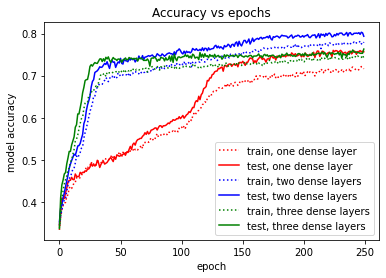

In [44]:
plt.plot(fit1.history['accuracy'], label='train, one dense layer', c='r', ls='dotted')
plt.plot(fit1.history['val_accuracy'], label='test, one dense layer', c='r')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.ylabel('model accuracy')
plt.xlabel('epoch')



plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

### adding conv1d

ciao
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_30 (Averag (None, 10, 5)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 4, 5)              180       
_________________________________________________________________
flatten_26 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_28 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 3)          

Epoch 71/250
32/32 - 0s - loss: 0.6634 - accuracy: 0.6850 - val_loss: 0.6270 - val_accuracy: 0.7195
Epoch 72/250
32/32 - 0s - loss: 0.6608 - accuracy: 0.6765 - val_loss: 0.6227 - val_accuracy: 0.7245
Epoch 73/250
32/32 - 0s - loss: 0.6620 - accuracy: 0.6800 - val_loss: 0.6235 - val_accuracy: 0.7240
Epoch 74/250
32/32 - 0s - loss: 0.6609 - accuracy: 0.6833 - val_loss: 0.6220 - val_accuracy: 0.7255
Epoch 75/250
32/32 - 0s - loss: 0.6613 - accuracy: 0.6812 - val_loss: 0.6198 - val_accuracy: 0.7260
Epoch 76/250
32/32 - 0s - loss: 0.6616 - accuracy: 0.6873 - val_loss: 0.6189 - val_accuracy: 0.7255
Epoch 77/250
32/32 - 0s - loss: 0.6567 - accuracy: 0.6881 - val_loss: 0.6209 - val_accuracy: 0.7310
Epoch 78/250
32/32 - 0s - loss: 0.6559 - accuracy: 0.6867 - val_loss: 0.6167 - val_accuracy: 0.7310
Epoch 79/250
32/32 - 0s - loss: 0.6533 - accuracy: 0.6877 - val_loss: 0.6170 - val_accuracy: 0.7305
Epoch 80/250
32/32 - 0s - loss: 0.6547 - accuracy: 0.6858 - val_loss: 0.6202 - val_accuracy: 0.7220


Epoch 153/250
32/32 - 0s - loss: 0.6173 - accuracy: 0.7165 - val_loss: 0.5989 - val_accuracy: 0.7355
Epoch 154/250
32/32 - 0s - loss: 0.6223 - accuracy: 0.7097 - val_loss: 0.5902 - val_accuracy: 0.7465
Epoch 155/250
32/32 - 0s - loss: 0.6202 - accuracy: 0.7136 - val_loss: 0.6180 - val_accuracy: 0.7265
Epoch 156/250
32/32 - 0s - loss: 0.6236 - accuracy: 0.7095 - val_loss: 0.5911 - val_accuracy: 0.7450
Epoch 157/250
32/32 - 0s - loss: 0.6163 - accuracy: 0.7178 - val_loss: 0.5999 - val_accuracy: 0.7340
Epoch 158/250
32/32 - 0s - loss: 0.6181 - accuracy: 0.7105 - val_loss: 0.5940 - val_accuracy: 0.7400
Epoch 159/250
32/32 - 0s - loss: 0.6158 - accuracy: 0.7156 - val_loss: 0.5881 - val_accuracy: 0.7425
Epoch 160/250
32/32 - 0s - loss: 0.6192 - accuracy: 0.7138 - val_loss: 0.5895 - val_accuracy: 0.7475
Epoch 161/250
32/32 - 0s - loss: 0.6178 - accuracy: 0.7115 - val_loss: 0.5906 - val_accuracy: 0.7415
Epoch 162/250
32/32 - 0s - loss: 0.6143 - accuracy: 0.7186 - val_loss: 0.5926 - val_accurac

32/32 - 0s - loss: 0.5936 - accuracy: 0.7324 - val_loss: 0.5764 - val_accuracy: 0.7505
Epoch 235/250
32/32 - 0s - loss: 0.5958 - accuracy: 0.7331 - val_loss: 0.5673 - val_accuracy: 0.7505
Epoch 236/250
32/32 - 0s - loss: 0.5946 - accuracy: 0.7297 - val_loss: 0.5673 - val_accuracy: 0.7515
Epoch 237/250
32/32 - 0s - loss: 0.5929 - accuracy: 0.7344 - val_loss: 0.5738 - val_accuracy: 0.7560
Epoch 238/250
32/32 - 0s - loss: 0.5897 - accuracy: 0.7336 - val_loss: 0.5692 - val_accuracy: 0.7555
Epoch 239/250
32/32 - 0s - loss: 0.5946 - accuracy: 0.7335 - val_loss: 0.5708 - val_accuracy: 0.7510
Epoch 240/250
32/32 - 0s - loss: 0.5956 - accuracy: 0.7360 - val_loss: 0.5732 - val_accuracy: 0.7500
Epoch 241/250
32/32 - 0s - loss: 0.5932 - accuracy: 0.7336 - val_loss: 0.5660 - val_accuracy: 0.7565
Epoch 242/250
32/32 - 0s - loss: 0.5936 - accuracy: 0.7299 - val_loss: 0.5679 - val_accuracy: 0.7590
Epoch 243/250
32/32 - 0s - loss: 0.5970 - accuracy: 0.7319 - val_loss: 0.5705 - val_accuracy: 0.7530
Epoc

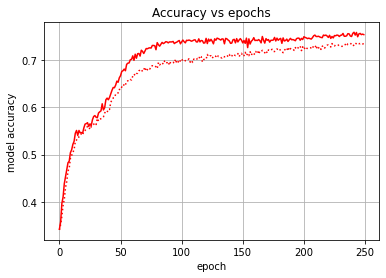

In [55]:

model = Sequential()
model.add(Conv1D(                                       #First layer:
                filters = 5,
                kernel_size = 11,                       #like Z = 12
                kernel_regularizer = reg,
                kernel_initializer = ini,
                activation = 'relu',
                input_shape = input_shape
                ))

model.add(AveragePooling1D(5)) #Reduce 5 -> 1

model.add(Conv1D(filters=5, kernel_size=7, activation=
                'relu'))

model.add(Flatten())                                     #Move to GNN
model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(N_categ,activation = 'softmax'))

print(model.summary()) 


model.compile(loss = tensorflow.keras.losses.categorical_crossentropy,
              optimizer = 'adam', metrics = ['accuracy'])


fit = model.fit(x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = (x_val,y_val),
                verbose = 2
               )


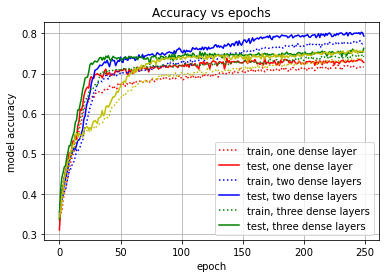

In [58]:
plt.plot(fit1.history['accuracy'], label='train, one dense layer', c='r', ls='dotted')
plt.plot(fit1.history['val_accuracy'], label='test, one dense layer', c='r')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()

plt.plot(fit2.history['accuracy'], label='train, two dense layers', c='b', ls='dotted')
plt.plot(fit2.history['val_accuracy'], label='test, two dense layers', c='b')
plt.ylabel('model accuracy')
plt.xlabel('epoch')



plt.plot(fit3.history['accuracy'], label='train, three dense layers', c='g', ls='dotted')
plt.plot(fit3.history['val_accuracy'], label='test, three dense layers', c='g')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()

plt.plot(fit.history['accuracy'], label='train, one dense layer', c='y', ls='dotted')
plt.plot(fit.history['val_accuracy'], label='test, one dense layer', c='y')
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()


In [11]:
!mkdir MODEL
fname ='MODEL/model'+str0+'.h5'
model.save(fname, save_format='h5')

model2 = keras.models.load_model(fname)
yhat_val = np.argmax(model2.predict(x_val), axis=-1)
ytrue_val = np.argmax(y_val, axis=-1)

for n in range(20):
    print(y_val[n], ytrue_val[n], yhat_val[n])

NameError: name 'keras' is not defined